In [1]:
import gym
import pybulletgym
import pybulletgym.envs
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import pinv
import time

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal

In [3]:
env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init = False)
#env.render()
env.reset()

current_dir=/home/apurba/.virtualenvs/276c_assgn/lib/python3.6/site-packages/pybullet_envs/bullet
options= 


array([ 0.3928371 ,  0.3928371 , -0.68091764,  0.26561381,  0.5       ,
        0.        ,  0.08333333,  0.        ])

In [4]:
learning_rate = 0.01
gamma = 0.90

num_states = env.observation_space.shape[0]
print(num_states)

9


In [5]:
#covariance should not be too large and not too small
#self.sigma= torch.nn.parameter(0.1)
#mu = self.network(state)
#m = multivariatenorm(mu, torch.abs(self.sigma)+ e^-3)
#targetx, targety,diffx,diffy, theta, theta_dot, r, gamma
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.state_num = 8
        self.action_num = 2
        
        #self.l1 = nn.Linear(self.state_num, 64, bias=False)
        #self.l2 = nn.Linear(64, 64, bias=False)
        #self.l3 = nn.Linear(64, self.action_num, bias=False)
        self.l1 = nn.Linear(self.state_num, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_num, bias=False)
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_episode = Variable(torch.Tensor()) 
        self.reward_episode = []   
        # Overall return history
        self.return_history = []
        self.return_reward = []
        self.return_history_stepzero = []
        
        self.policy_episode_eval = Variable(torch.Tensor()) 
        self.reward_episode_eval = []   

        
        self.episodesPeriter = []
        self.sigmax = torch.nn.Parameter(torch.FloatTensor([0.1]))
        self.sigmay = torch.nn.Parameter(torch.FloatTensor([0.1]))
        #self.sigma = torch.nn.Parameter(torch.tensor([[0.1, 0], [0, 0.1]]))
        



    def forward(self, x):
        
        model = torch.nn.Sequential(
                                    self.l1,
                                    nn.Dropout(p=0.6),
                                    #nn.ReLU(),
                                    nn.Tanh(),
                                    self.l2,
                                    #nn.Dropout(p=0.6),
                                    #nn.Tanh(),
                                    #self.l3,
                                    nn.Tanh()
                                    )
        return model(x)

   

 

In [6]:
class modtwoLink ():
    

    
    def __init__(self, env, policy, part, totsteps, iterationsNo, learning_rate, gamma):
        self.env = env
        self.policy = policy
        self.part = part
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.iterationsNo = iterationsNo
        self.totsteps = totsteps
        
        self.iterations = []
        
        self.polHist_allepisodes = Variable(torch.Tensor())
        self.rewHist_allepisodes = Variable(torch.Tensor())
        self.rewHist_allepisodes_mod = Variable(torch.Tensor())
    
    def select_action(self, state):
 
    
        #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
        state = torch.from_numpy(state).type(torch.FloatTensor)
        probs = self.policy(state)#this will give the mean of x and y
        mux = policy.sigmax.reshape(1)
        muy = policy.sigmay.reshape(1)
        if(mux < 0.001):
            mux = mux + 0.001
        if(muy < 0.001):
            muy = muy + 0.001
        covariance = torch.cat([mux, muy])
        #print(covariance)
        covariance_tensor = torch.FloatTensor(covariance)
        c = MultivariateNormal(probs, torch.diag(torch.abs(covariance_tensor)))
        #print(self.policy.sigma)
        #c = MultivariateNormal(probs, self.policy.sigma)
        action = c.sample()

        if len(self.policy.policy_episode) > 0:
            self.policy.policy_episode = torch.cat([self.policy.policy_episode, c.log_prob(action).reshape(1)])
        else:
            self.policy.policy_episode = (c.log_prob(action).reshape(1))
        return action

    def rewardFunction(self, polHistory, rewHistory, part = 1):

        Rewards_tot = 0
        rewards = []
        for Reward in rewHistory[::-1]:
            Rewards_tot = Reward + self.policy.gamma * Rewards_tot
            rewards.insert(0, Rewards_tot)

        if(self.part == 1):
            #gainPerStep = rewards[0]
            gainPerStep = sum(rewHistory)
            gainZeroStep = rewards[0]
            reward = rewards[0]*torch.sum(polHistory)
            


        if(self.part == 2):
            gainPerStep = sum(rewHistory)
            gainZeroStep = rewards[0]
            rewards = torch.FloatTensor(rewards)
            reward = torch.sum(torch.mul(polHistory, rewards))
        
        if(self.part == 3):
            gainPerStep = sum(rewHistory)
            gainZeroStep = rewards[0]
            rewards = torch.FloatTensor(rewards)

            if (len(self.polHist_allepisodes) > 0):

                self.polHist_allepisodes = torch.cat([self.polHist_allepisodes, polHistory])
                self.rewHist_allepisodes = torch.cat([self.rewHist_allepisodes, rewards])
            else:
                self.polHist_allepisodes = polHistory
                self.rewHist_allepisodes = rewards

            
            #self.rewHist_allepisodes = (self.rewHist_allepisodes - self.rewHist_allepisodes.mean())/ (self.rewHist_allepisodes.std())
            self.rewHist_allepisodes_mod = (self.rewHist_allepisodes - self.rewHist_allepisodes.mean())/ (self.rewHist_allepisodes.std())
            reward = torch.sum(torch.mul(self.polHist_allepisodes, self.rewHist_allepisodes_mod))
            #print(reward)
        
        
        return reward, gainPerStep, gainZeroStep
    
    
    def update_policy(self, reward, retTraj_tot, retTraj_tot_stepzero, episodes_iter):
        #print("in update")
        # Update network weights
        self.optimizer.zero_grad()
        #print(reward)
        reward.backward()
        self.optimizer.step()
        self.policy.return_history.append(retTraj_tot)
        #self.policy.return_reward.append(reward)
        self.policy.return_history_stepzero.append(retTraj_tot_stepzero)
        self.policy.episodesPeriter.append(episodes_iter)
    
    def reinforceAlgo(self):
    #running_reward = 10
    
        for iter in range(self.iterationsNo):
            self.polHist_allepisodes = Variable(torch.Tensor())
            self.rewHist_allepisodes = Variable(torch.Tensor())
            #print("iteration no",iter)
            steps = 0
            state = env.reset() # Reset environment, starting state recorded
            done = False
            episodes = 0;
            rewardFunc = Variable(torch.FloatTensor([0])) 
            rewardEpisode = Variable(torch.FloatTensor()) 
            retTraj_tot = 0
            retStepzero_tot = 0
            #optimizer.zero_grad()
            while(steps < self.totsteps):
                steps += 1;
                action = self.select_action(state)
                # Step through environment using chosen action
                state, reward, done, _ = env.step(action)
                #env.render()
            
            # Save reward
                self.policy.reward_episode.append(reward)
                if (done == True):
                    rewardEpisode, retTraj, retStepzero = self.rewardFunction(self.policy.policy_episode, self.policy.reward_episode, self.part)
                    if(self.part != 3):
                        rewardFunc += rewardEpisode
                    retTraj_tot += retTraj
                    retStepzero_tot += retStepzero
                    #reset the environment again
                    self.policy.policy_episode = Variable(torch.Tensor()) 
                    self.policy.reward_episode = []
                    state = env.reset()
                    done = False
                    episodes += 1
                
            if(self.part == 3):
                 rewardFunc += rewardEpisode
            if(episodes > 0):
                self.update_policy(-1 * rewardFunc/episodes, retTraj_tot/episodes,retStepzero_tot/episodes, episodes)
            else:
                self.update_policy(-1 * rewardFunc, retTraj_tot, retStepzero_tot, 0)
            self.iterations.append(iter)
    
    


In [7]:
state = env.reset()
policy = PolicyNetwork()
twoLink = modtwoLink(env= env, policy = policy, part = 3, totsteps = 1000, iterationsNo = 110, learning_rate = 0.01, gamma = 0.90)
twoLink.reinforceAlgo()


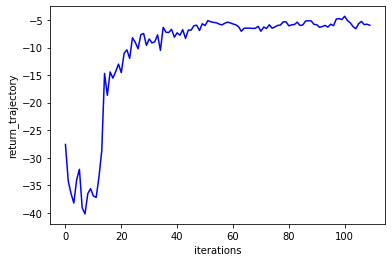

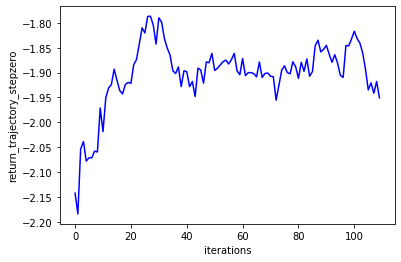

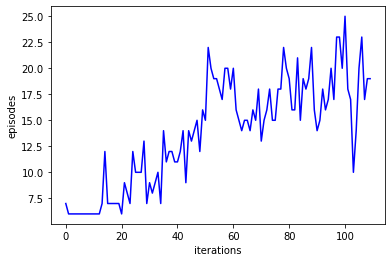

In [8]:
plt.plot(twoLink.iterations,twoLink.policy.return_history, color='b');
plt.xlabel("iterations")
plt.ylabel("return_trajectory")
plt.show()

plt.plot(twoLink.iterations,twoLink.policy.return_history_stepzero, color='b');
plt.xlabel("iterations")
plt.ylabel("return_trajectory_stepzero")
plt.show()


plt.plot(twoLink.iterations,twoLink.policy.episodesPeriter, color='b');
plt.xlabel("iterations")
plt.ylabel("episodes")
plt.show()

In [9]:
def select_action_eval(state):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    action = policy(state)#this will give the mean of x and y



    return action

In [10]:
env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
steps = 0
env.render('human')
state = env.reset()
done = False
while (steps<300 and done == False):
        action = select_action_eval(state)
        action_np = action.detach().numpy()
        state, r, done, info = env.step(action_np)
        steps+=1
        env.render('human')
        time.sleep(0.1)
        print(done)

print(steps)

options= 
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
51


In [3]:
env.close()

NameError: name 'env' is not defined